# Introduction
## 6.1  Define the Task

#### Dataset Information
Dataset will be the cifar100 dataset from tensorflow. This is a multi-class classification problem with 100 different classes of images to be classified. There are 500 training images and 100 testing images for each of the 100 classes so this is a balanced dataset.

#### Accuracy Metric
Balanced classification problems such as this a good measure of success will be accuracy and area under the reciever operating characteristic curve. Guessing all one type of class would lead to an accuracy of 1% since there are 100 different classes. 

#### Evaluation
The model will be evaluated using a holdout test set of 10,000 images consisting of 100 of each class. The training set will consist of 500 images of each class for a total of 50,000 images.




In [39]:
### Show data class information metrics
## show that the counts of the labels are balanced

In [40]:
from tensorflow.keras.datasets import cifar100


This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

## 6.2 Develop a Model
### Data Preparation

The data consists of images that are 32x32.  There are 50,000 training images and 10,000 test images. 

## Examine the data

In [56]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

In [57]:
print('tensor shape')
print('\ttraining images:', train_images.shape)
print('\ttraining labels:', train_labels.shape)
print('\ttraining images:', train_images.dtype)
print('\ttraining labels:', train_labels.dtype)
print('\ttest images:', test_images.shape)
print('\ttest labels:', test_labels.shape)

tensor shape
	training images: (50000, 32, 32, 3)
	training labels: (50000, 1)
	training images: uint8
	training labels: int32
	test images: (10000, 32, 32, 3)
	test labels: (10000, 1)


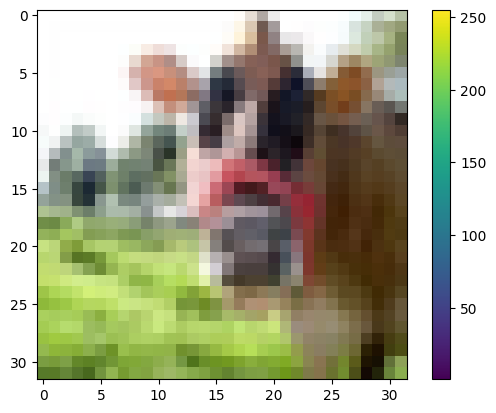

In [58]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Preprocess
1. Reshape to flatten 32x32x3 to vector
2. Cast vector as floats
3. Rescale from [0,1]

In [59]:
train_images_flat = train_images.reshape((50000, 32*32*3)).astype('float32') / 255.
test_images_flat = test_images.reshape((10000, 32*32*3)).astype('float32') / 255.


In [60]:
train_labels

array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [61]:
from tensorflow.keras.utils import to_categorical

orig_label = train_labels[0]
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [62]:

print('\'', orig_label, '\'', 'as one-hot vector:\n', train_labels[0], sep='')

'[19]'as one-hot vector:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


### Baseline Model
Start smal, smallest amout of layers can do and small # of units then increase size

Only a baseline model if it has "statistical power" meaning ??

**Selecting loss function**
Chose categorical crossentropy but why?
General loss function for classification tasks where the evaluation metric is RCO AUC - need to figure out why that is. Used as a proxy, hope is that the lower the crossentropy the higher the ROC AUC will be 

**Final Layer**  
Multi-class single label classification => 
* last layer activation: **softmax**  
* Loss function: **categorical_crossentropy**


In [63]:
# build
from tensorflow.keras import models, layers

# create empty network
network = models.Sequential()

# add 2 layers
network.add(layers.Dense(64, activation='relu', input_shape=(32 * 32 * 3, )))
network.add(layers.Dense(100, activation='softmax'))

network.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

network.fit(train_images_flat, train_labels, epochs=5, batch_size=128)

Epoch 1/5
391/391 [==============================] - 3s 7ms/step - loss: 4.4360 - accuracy: 0.0322
Epoch 2/5
391/391 [==============================] - 2s 6ms/step - loss: 4.0814 - accuracy: 0.0766
Epoch 3/5
391/391 [==============================] - 2s 6ms/step - loss: 3.9119 - accuracy: 0.1049
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: 3.8109 - accuracy: 0.1205
Epoch 5/5
391/391 [==============================] - 2s 6ms/step - loss: 3.7522 - accuracy: 0.1319


Base model has achieved an 11.5% accuracy which is higher than 10% if we were to randomly guess so this is a suitable base model on which to improve upon.

### 6.2.4 Develop a model that overfits
Once have model with statistical power => question is now is model sufficiently powerful?  
Enough layers? Enough Parameters? to properly model problem at hand  
Universal tension in ML is optimization vs generalization  

To figure out how big a model must develop model that overfits  
1. Add layers
2. make layers bigger
3. train for more epochs

Monitor the training loss and validation loss as well as training and validation values for any metrics that you care about  

**Overfitting:** Once see that model's performance on validation data begins to degrade


Run a 2 layer model layer with large units. 
Train for 30 epochs to see where overfitting starts to occur. 


In [185]:
from keras.callbacks import CSVLogger

def build_network(units_list, learning_rate=0.01, epochs=5, log_name='log', optimizer='rmsprop'):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units))
    
    #last layer
    network.add(layers.Dense(100, activation='softmax'))
    
    
    network.compile(optimizer=optimizer,
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    log_name = log_name + '.csv'
    csv_logger = CSVLogger(log_name, append=False, separator=',')
    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=0,
        callbacks=[csv_logger],
        validation_split=0.2
    )

    return history

Build a 2 layer network and overfit

In [136]:
overfit_2_layer_history = build_network([512, 512], 0.01, 30)


Build a 2 layer network using the 'adam' optimizer instead of rmsprop and overfit for 30 epochs and compare to the 'rmsprop' optimizer model. 

In [168]:
overfit_2_layer_adam_history = build_network([512, 512], 0.01, 30, optimizer='adam')

Build a 3 layer network and overfit for 30 epochs to compare to 2 layer model.

In [138]:
overfit_3_layer_history = build_network([512, 512, 512], 0.01, 30)


Plot Training and Validation Loss and Training and Validation Accuracy

In [133]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training acc')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

Compare the training and validation accuracies and losses of 2 models. 

In [159]:
def compare_loss(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss']
    val_loss_drop = hist2.history['val_loss']

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = f'{title1} Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = f'{title1} Validation loss')
    plt.plot(epochs, loss_drop, red_dots, label = f'{title2} Training loss')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = f'{title2} Validation loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy']
    val_acc_drop = hist2.history['val_accuracy']

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training acc')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation acc')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


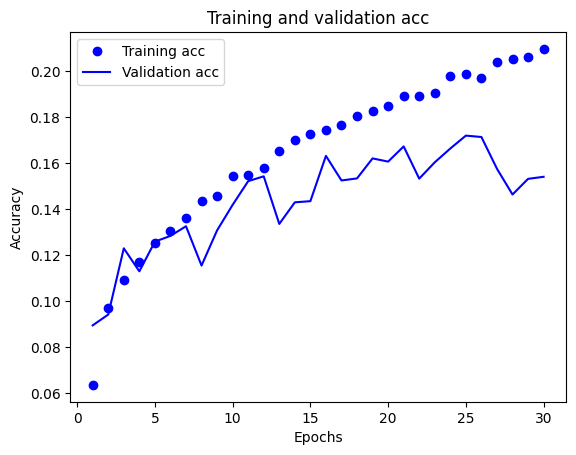

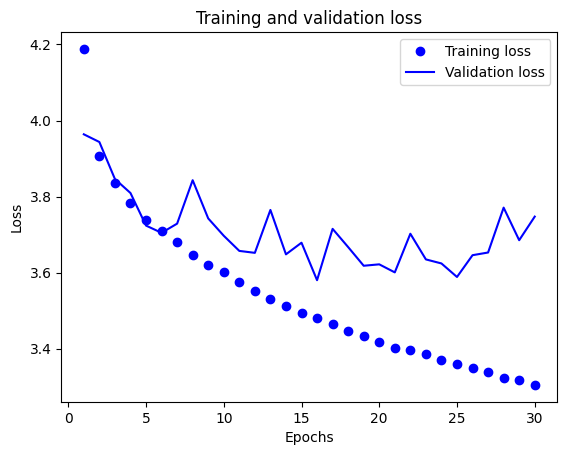

In [151]:
plot_train_val_acc(overfit_2_layer_history)
plot_train_val_loss(overfit_2_layer_history)

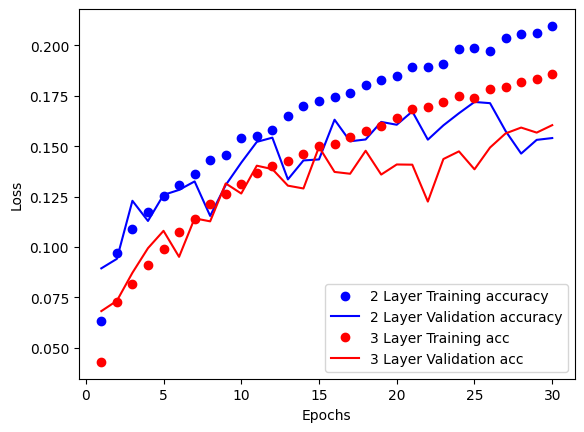

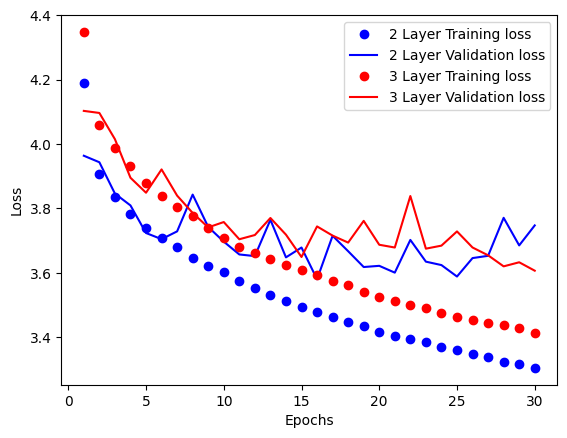

In [152]:
compare_acc(overfit_2_layer_history, overfit_3_layer_history, '2 Layer', '3 Layer')
compare_loss(overfit_2_layer_history, overfit_3_layer_history, '2 Layer', '3 Layer')

When looking at the 2 layer model, from the training accuracy and validation accuracy plots we begin to see overfitting after about 22-24 epochs. The loss plot shows overfitting beginning around 23-25 epochs as well. 

Looking at 3 layer model don't see much improvement to the validation accuracy or loss beyond the results achieved from the 2 layer model. Can see that loss is overall lower in the 2 layer model than the 3 and that accuracy is higher in the 2 layer model than the 3 layer model. 

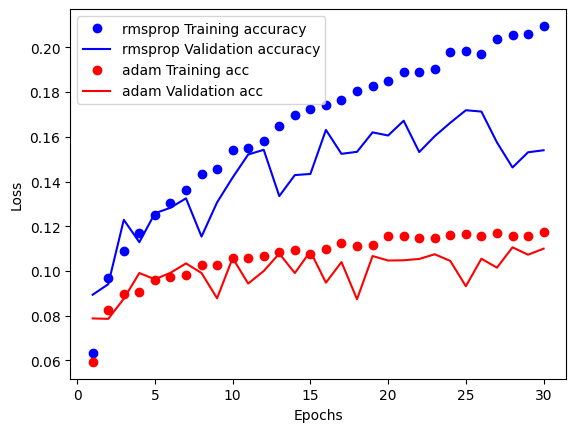

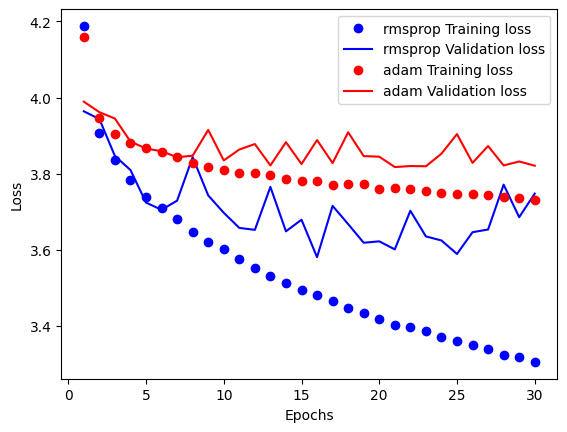

In [169]:
compare_acc(overfit_2_layer_history, overfit_2_layer_adam_history, 'rmsprop', 'adam')
compare_loss(overfit_2_layer_history, overfit_2_layer_adam_history, 'rmsprop', 'adam')

When comparing the use of the rmsprop optimizer compared to the adam optimizer the plots show that the rmsprop optimizer outperforms adam. 

## Hyperparameter search space
**Layers**  
1,2  
**Units**  
[64, 128, 512, 1024]  
**Learning Rate**  
[0.001, 0.01, 0.1, 0.5]

In [176]:
unit_space = [64, 128, 512, 1024]
learning_rate_space = [0.001, 0.01, 0.1,0.5]
layer_space = [1,2]


In [191]:
def get_search_grid(unit_space, learning_rate_space, layer_space):
    search_space = []
    for units in unit_space:
        for lr in learning_rate_space:
            search_space.append([[units], lr])
    space1_len = len(search_space)
    print('Search layer 1 length: ', space1_len)
    for units1 in unit_space:
        for units2 in unit_space:
            for lr in learning_rate_space:
                search_space.append([[units1, units2],lr])
    space2_len = len(search_space) - space1_len
    print('Search layer 2 length: ', space2_len)
    # for u1 in unit_space:
    #     for u2 in unit_space:
    #         for u3 in unit_space:
    #             for lr in learning_rate_space:
    #                 search_space.append([[u1, u2, u3], lr])
    # space3_len = len(search_space) - space1_len - space2_len
    # print('Search layer 3 length: ', space3_len)
    return search_space

search_space = get_search_grid(unit_space, learning_rate_space, layer_space)

Search layer 1 length:  16
Search layer 2 length:  64


In [154]:
# use this to break down search space so don't have to run so long
search_space_1 = search_space[:15]
search_space_2 = search_space[15: 90]
# search_space_3 = search_space[90:]

In [186]:

def run_grid_search(search_space, log_name):
    accuracy_train_history = []
    accuracy_val_history = []
    loss_train_history = []
    loss_val_history = []
    for params in search_space:
        history = build_network(params[0], params[1], epochs=10, log_name=log_name)
        accuracy_train_history.append(history.history['accuracy'])
        accuracy_val_history.append(history.history['val_accuracy'])
        loss_train_history.append(history.history['loss'])
        loss_val_history.append(history.history['val_loss'])
    
    return accuracy_train_history,accuracy_val_history, loss_train_history, loss_val_history

In [213]:

def run_grid_search2(search_space, log_name, epochs):
    histories = []
    for params in search_space:
        history = build_network(params[0], params[1], epochs=epochs, log_name=log_name)
        histories.append(history.history)
    
    return histories

In [205]:
test_histories = run_grid_search2(search_space[:8], 'test_log')

In [210]:
all_histories = run_grid_search2(search_space, 'log2', 7)

In [208]:
import numpy as np

def get_max_hist_index2(hist):
    last_values = []
    for val in hist:
        last_values.append(val[-1])
    index_max = np.argmax(last_values)
    return index_max


def print_best_params2(params, hist):
    layers = params[0]
    lr = params[1]
    layers_text = ''
    for count, layer in enumerate(layers):
        layers_text = layers_text + 'Layer #' + str(count + 1) + ' units:' + str(layer) + '\t'
    print(layers_text, '\t', 'Learning Rate: ', lr)
    print('Accuracy: ', hist['val_accuracy'])

def get_max_params2(search_space, histories):
    validation_accuracies = []
    for hist in histories:
        validation_accuracies.append(hist['val_accuracy'])
    max_index = get_max_hist_index2(validation_accuracies)
    print('Max accuracy index: ', max_index)
    
    max_val_acc_hist = histories[max_index]
    # max_val_loss = loss_val_hist[max_index]
    params = search_space[max_index]
    
    print_best_params2(params, max_val_acc_hist)
    return params, max_val_acc_hist
 


In [209]:
test_params, test_max_val_acc = get_max_params2(search_space[:8], test_histories)

Max accuracy index:  5
Layer #1 units:128	 	 Learning Rate:  0.01
Accuracy:  [0.03929999843239784, 0.07569999992847443, 0.0949999988079071]


In [211]:
best_params_val, best_max_val_acc = get_max_params2(search_space, all_histories)

Max accuracy index:  69
Layer #1 units:1024	Layer #2 units:128	 	 Learning Rate:  0.01
Accuracy:  [0.09430000185966492, 0.1257999986410141, 0.1509000062942505]


Ran this before taking into account validation accuarcy and loss, before was only looking at training accuracy and loss

In [187]:
acc_hist_12_layers, los_hist_12_layers = run_grid_search(search_space, '1and2layerslog')

New grid search to maximize validation accuracy and min validation loss rather than training. 

In [ ]:
hist_12_acc_train, hist_12_acc_val, hist_12_loss_train, hist_12_loss_val = run_grid_search(search_space, '1and2layerslogval')

In [80]:
import numpy as np

def get_max_hist_index(hist):
    last_values = []
    for val in hist:
        last_values.append(val[-1])
    index_max = np.argmax(last_values)
    return index_max


def print_best_params(params, acc, loss):
    layers = params[0]
    lr = params[1]
    layers_text = ''
    for count, layer in enumerate(layers):
        layers_text = layers_text + 'Layer #' + str(count + 1) + ' units:' + str(layer) + '\t'
    print(layers_text, '\t', 'Learning Rate: ', lr)
    print('Accuracy: ', acc)
    print('Loss: ', loss)

def get_max_params(search_space, acc_val_hist, loss_val_hist):
    max_index = get_max_hist_index(acc_val_hist)
    print('Max accuracy index: ', max_index)
    
    max_val_acc = acc_val_hist[max_index]
    max_val_loss = loss_val_hist[max_index]
    params = search_space[max_index]
    
    print_best_params(params, max_val_acc, max_val_loss)
    return params, max_val_acc, max_val_loss
 


In [82]:
best_params_1_layer, best_acc_1_layer, best_loss_1_layer = get_max_params(search_space_1, acc_hist_1_layer, loss_hist_1_layer)

best_params_2_layer, best_acc_2_layer, best_loss_2_layer = get_max_params(search_space_2, acc_hist_2_layer, loss_hist_2_layer)

Max accuracy index:  14
Layer #1 units:1024	 	 Learning Rate:  0.3
Accuracy:  [0.0846799984574318, 0.13312000036239624, 0.1453399956226349, 0.14730000495910645, 0.14781999588012695]
Loss:  [4.116531848907471, 3.7744545936584473, 3.717397451400757, 3.7073824405670166, 3.711656332015991]
Max accuracy index:  62
Layer #1 units:1024	Layer #2 units:64	 	 Learning Rate:  0.3
Accuracy:  [0.07968000322580338, 0.12814000248908997, 0.14485999941825867, 0.15785999596118927, 0.1694200038909912]
Loss:  [4.115638732910156, 3.7573752403259277, 3.657493829727173, 3.5927412509918213, 3.547614574432373]


In [188]:
bestparams12, best_acc12, best_loss12 = get_max_params(search_space, acc_hist_12_layers, los_hist_12_layers)

Max accuracy index:  65
Layer #1 units:1024	Layer #2 units:64	 	 Learning Rate:  0.01
Accuracy:  [0.07154999673366547, 0.11874999850988388, 0.14087499678134918, 0.15337499976158142, 0.16554999351501465, 0.17492499947547913, 0.1829250007867813, 0.1881999969482422, 0.1940000057220459, 0.19802500307559967]
Loss:  [4.1875901222229, 3.8051207065582275, 3.6905856132507324, 3.604398488998413, 3.546518325805664, 3.49987530708313, 3.46626877784729, 3.434767484664917, 3.404872179031372, 3.3792221546173096]


Find the best paramaters were a 2 layer model with first layer having 1024 units and second having 64 with a learning rate of 0.01. 

### Try Overfitting
Run for 30 epochs

In [189]:
best_network_hist = build_network(bestparams12[0], bestparams12[1], 30)

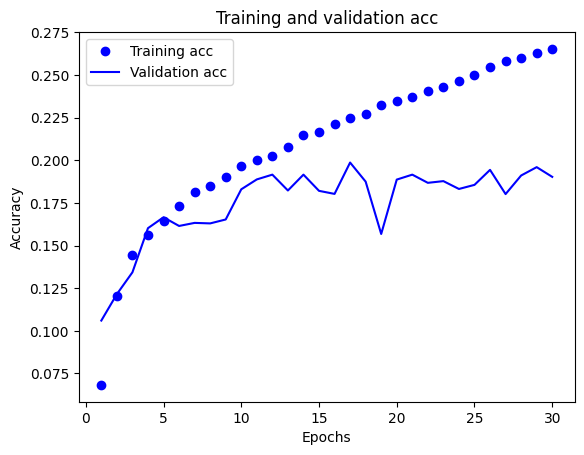

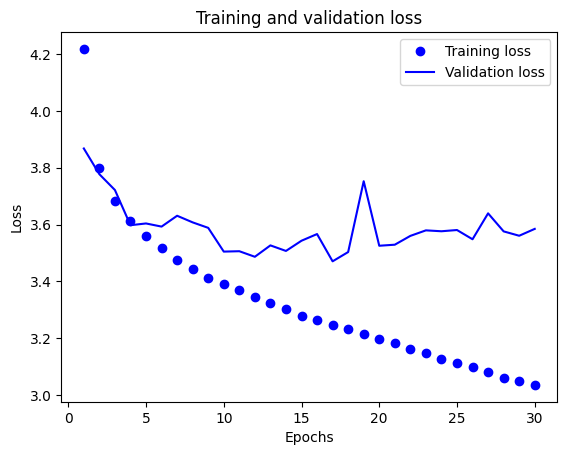

In [190]:
plot_train_val_acc(best_network_hist)
plot_train_val_loss(best_network_hist)

Training accuracy continues to increase while validation accuracy levels off around 17-18 epochs. After this we get overfitting.

This is in line with the validation loss which stops decreasing around 15 epochs while training loss steadily decreases past this point confirming that overfitting has been achieved. 

### 6.2.5 Hyperparamater tuning

goal now is to maximize generalization performance  
repeatedly modify model and train it and evaluate it (**on evaluation data NOT test data**)  



**Search Space**
1. learning rate - already tuned for, could look more deeply at this
2. units - also already tuned for in the grid search but could again increase units
3. layers
    ii. add or remove layers
4. add dropout

In [105]:

def build_network_w_dropout(units_list, learning_rate=0.01, epochs=16, dropout_rate=0.5):
    network = models.Sequential()
    
    #first layer - needs input_shape
    network.add(layers.Dense(units_list[0], activation='relu', input_shape=(32 * 32 * 3, )))
    network.add(layers.Dropout(dropout_rate))
    
    #middle layers
    for units in units_list[1:]:
        network.add(layers.Dense(units))
        network.add(layers.Dropout(dropout_rate))
    
    #last layer
    network.add(layers.Dense(100, activation='softmax'))
    
    
    network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    csv_logger = CSVLogger('log.csv', append=True, separator=',')
    history = network.fit(
        train_images_flat, train_labels, 
        epochs=epochs, 
        verbose=2,
        callbacks=[csv_logger],
        validation_split=0.2
    )

    return history

In [106]:
layer2_hist_drop = build_network_w_dropout(best_params_2_layer[0], best_params_2_layer[1], 16)

Epoch 1/16
1250/1250 - 51s - loss: 4.5871 - accuracy: 0.0218 - val_loss: 4.3604 - val_accuracy: 0.0419 - 51s/epoch - 41ms/step
Epoch 2/16
1250/1250 - 48s - loss: 4.4455 - accuracy: 0.0305 - val_loss: 4.3194 - val_accuracy: 0.0516 - 48s/epoch - 38ms/step
Epoch 3/16
1250/1250 - 48s - loss: 4.4075 - accuracy: 0.0322 - val_loss: 4.2273 - val_accuracy: 0.0627 - 48s/epoch - 39ms/step
Epoch 4/16
1250/1250 - 48s - loss: 4.3680 - accuracy: 0.0369 - val_loss: 4.2376 - val_accuracy: 0.0688 - 48s/epoch - 38ms/step
Epoch 5/16
1250/1250 - 47s - loss: 4.3383 - accuracy: 0.0400 - val_loss: 4.2100 - val_accuracy: 0.0719 - 47s/epoch - 38ms/step
Epoch 6/16
1250/1250 - 49s - loss: 4.3102 - accuracy: 0.0452 - val_loss: 4.1539 - val_accuracy: 0.0871 - 49s/epoch - 39ms/step
Epoch 7/16
1250/1250 - 47s - loss: 4.2913 - accuracy: 0.0480 - val_loss: 4.1262 - val_accuracy: 0.0797 - 47s/epoch - 38ms/step
Epoch 8/16
1250/1250 - 47s - loss: 4.2763 - accuracy: 0.0511 - val_loss: 4.1381 - val_accuracy: 0.0793 - 47s/ep

Compare without dropout

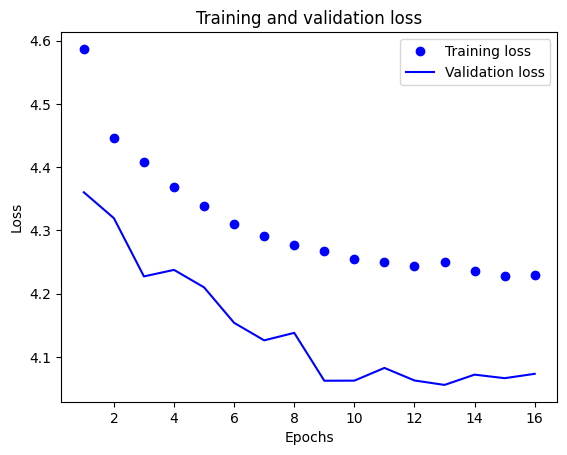

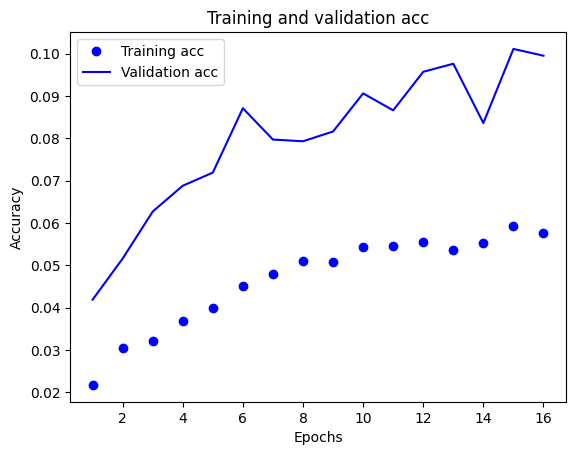

In [107]:
plot_train_val_loss(layer2_hist_drop)
plot_train_val_acc(layer2_hist_drop)

16


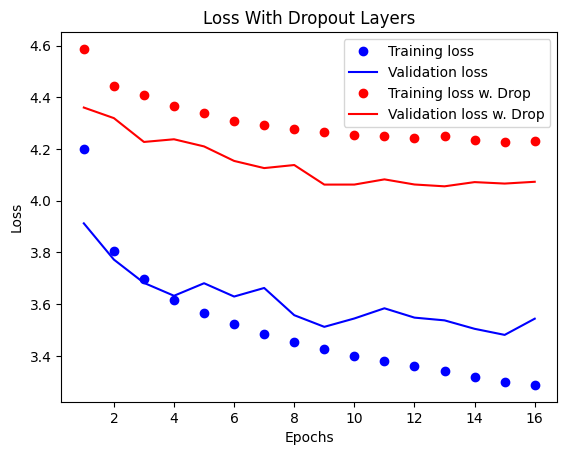

In [129]:
def compare_loss(hist1, hist2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    loss = hist1.history['loss'][:min_epochs]
    val_loss = hist1.history['val_loss'][:min_epochs]
    loss_drop = hist2.history['loss']
    val_loss_drop = hist2.history['val_loss']

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.plot(epochs, loss_drop, red_dots, label = 'Training loss w. Drop')
    plt.plot(epochs, val_loss_drop, solid_red_line, label = 'Validation loss w. Drop')
    plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

compare_loss(layer2_hist,layer2_hist_drop)

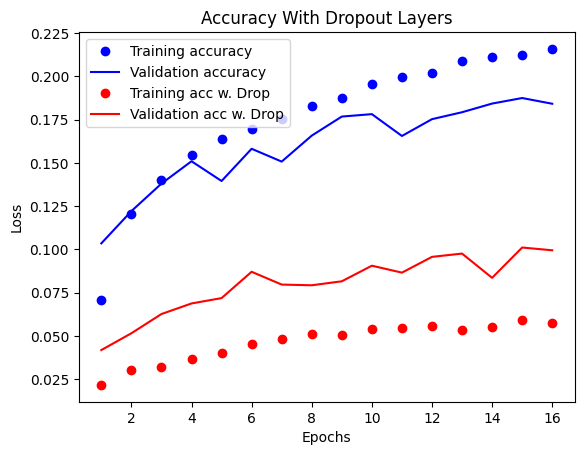

In [132]:

compare_acc(layer2_hist,layer2_hist_drop)

Can see from the results that including dropout layers does not improve model accuracy, both training accuracy and validation accuracy decrease. Also training loss and validation loss also increase with the inclusion of dropout layers. 